In [10]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import math
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(5*5 * 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 5*5 * 64)))
        x = self.fc2(x)
        # print("x = ",x.size(), x)
        return x

In [3]:
#2 
def train_model(model, train_input, train_target, mini_batch_size):
    # We do this with mini-batches
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=η, momentum=0.3)
    # print("Size = ", train_input.size(), train_target.size())
    acc_loss = 0
    for b in range(0, train_input.size(0), mini_batch_size):
        #--------------
          # torch.narrow(input, dim, start, length) → Tensor
        #--------------
        # print("train_input.narrow",train_input.narrow(0, b, mini_batch_size).size())
        output = model(train_input.narrow(0, b, mini_batch_size))#表示取出train_input中第0维上索引从b开始到index+mini_batch_size-1的所有元素
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        model.zero_grad()
        loss.backward()
        optimizer.step()

    return model, acc_loss 

In [8]:
import dlc_practical_prologue as prologue
N = 1000
data = prologue.generate_pair_sets(N)
train_data = data[:3]
test_data = data[3:]

train_input, train_target, train_classes = train_data[0], train_data[1], train_data[2]
test_input, test_target, test_classes = test_data[0], test_data[1], test_data[2]
print(train_input.size(), train_target.size(), train_classes.size())

train_input_1 =  train_input[:,0].unsqueeze(1)
train_input_2 =  train_input[:,1].unsqueeze(1)
train_classes_1 =  train_classes[:,0]
train_classes_2 =  train_classes[:,1]
test_input_1 =  test_input[:,0].unsqueeze(1)
test_input_2 =  test_input[:,1].unsqueeze(1)
test_classes_1 =  test_classes[:,0]
test_classes_2 =  test_classes[:,1]
print(test_input_1.size(), test_classes_1.size(),test_classes_1[1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2])
torch.Size([1000, 1, 14, 14]) torch.Size([1000]) tensor(4)


In [5]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size):
  error = 0
  output_class = torch.ones(data_input.size(0))
  for b in range(0, data_input.size(0), mini_batch_size): 
    output = model(data_input.narrow(0, b, mini_batch_size))
    
    for i in range(mini_batch_size): 
      output_class[b+i] = torch.argmax(output[i])
      if output_class[b+i] != data_target[b+i]:
        error += 1
  acc = 1 - (error/data_input.size(0))
  return acc, output_class

In [6]:
import matplotlib.pyplot as plt

def my_plot(epochs, accu):
    plt.plot(epochs, accu)


test_input_1 acc :  0.928


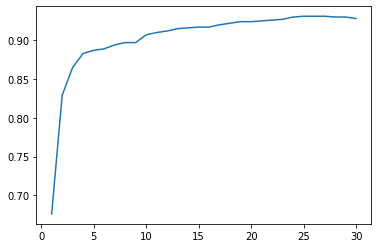

In [13]:
model = Net()
η = 0.002 #If it too big, it will fail!
mini_batch_size = 50
nb_epochs =30
acc_epoch = []
#print(train_input, train_target)
for e in range(nb_epochs):
    #print(train_input_1, train_classes_1)
    model, acc_loss = train_model(model, train_input_1, train_classes_1, mini_batch_size)
    acc, output_class_1 = compute_nb_errors(model, test_input_1, test_classes_1, mini_batch_size)
    # print('epoch :', e, ' loss :', round(acc_loss))
    # print('acc : ', acc)
    # print('----------')
    acc_epoch.append(acc)
# plotting
my_plot(np.linspace(1, nb_epochs, nb_epochs).astype(int), acc_epoch)
print('test_input_1 acc : ', acc)
model1 = model #save first input training model


test_input_1 acc :  0.943


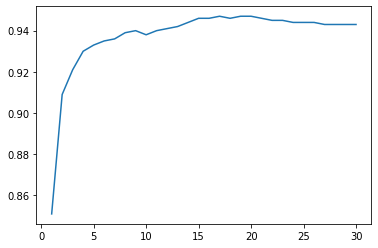

In [17]:
model = Net()
η = 0.002 #If it too big, it will fail!
mini_batch_size = 50
nb_epochs =30
acc_epoch = []
#print(train_input, train_target)
for e in range(nb_epochs):
    #print(train_input_1, train_classes_1)
    model, acc_loss = train_model(model, train_input_1, train_classes_1, mini_batch_size)
    acc, output_class_1 = compute_nb_errors(model, test_input_1, test_classes_1, mini_batch_size)
    model, acc_loss = train_model(model, train_input_2, train_classes_2, mini_batch_size)
    acc, output_class_2 = compute_nb_errors(model, test_input_2, test_classes_2, mini_batch_size)
    
    # print('epoch :', e, ' loss :', round(acc_loss))
    # print('acc : ', acc)
    # print('----------')
    acc_epoch.append(acc)
# plotting
my_plot(np.linspace(1, nb_epochs, nb_epochs).astype(int), acc_epoch)
print('test_input_1 acc : ', acc)
model1 = model #save first input training model

In [18]:
from torchsummary import summary
summary(model1, (1, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             320
            Conv2d-2           [-1, 64, 10, 10]          18,496
            Linear-3                  [-1, 200]         320,200
            Linear-4                   [-1, 10]           2,010
Total params: 341,026
Trainable params: 341,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.30
Estimated Total Size (MB): 1.39
----------------------------------------------------------------


test_input_2 acc :  0.9390000000000001


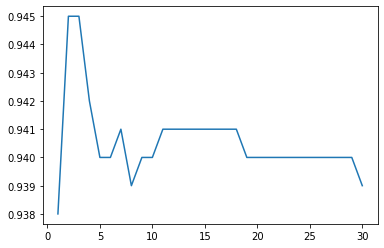

In [15]:
# [Method 1: Train on the same Model] train_input_1 & train_input_2  
acc_epoch_2 = []
for e in range(nb_epochs):
    model, acc_loss = train_model(model, train_input_2, train_classes_2, mini_batch_size)
    acc, output_class_2 = compute_nb_errors(model, test_input_2, test_classes_2, mini_batch_size)
    # print('epoch :', e, ' loss :', round(acc_loss))
    # print('acc : ', acc)
    # print('----------')
    acc_epoch_2.append(acc)
# plotting
my_plot(np.linspace(1, nb_epochs, nb_epochs).astype(int), acc_epoch_2)
print('test_input_2 acc : ', acc)

test_input_2 acc :  0.9390000000000001


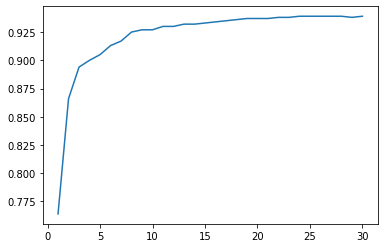

In [16]:
# [Method 2: Train on two Models] train_input_1 & train_input_2  
model2 = Net()
acc_epoch_3 = []
for e in range(nb_epochs):
    model2, acc_loss2 = train_model(model2, train_input_2, train_classes_2, mini_batch_size)
    acc2, output_class2_2 = compute_nb_errors(model2, test_input_2, test_classes_2, mini_batch_size)
    # print('epoch :', e, ' loss :', round(acc_loss2))
    # print('acc : ', acc2)
    # print('----------')
    acc_epoch_3.append(acc2)
# plotting
my_plot(np.linspace(1, nb_epochs, nb_epochs).astype(int), acc_epoch_3)
print('test_input_2 acc : ', acc2)

In [9]:
def compute_num_errors(data_ouput, data_target):
  error = 0
  for i in range(data_ouput.size(0)): 
      if data_ouput[i] != data_target[i]:
        error += 1
  acc = 1 - (error/data_ouput.size(0))
  return acc

In [10]:
def predict_target(data_output1, data_output2):
  output = torch.ones(len(data_output1))
  for i in range(len(data_output1)):
    if data_output1[i].item() > data_output2[i].item():
        output[i] = 0
    else:
        output[i] = 1
    
    #print("**",test_classes_1[i], test_classes_2[i], test_target[i])
    #print(data_output1[i].item(), data_output2[i].item(), output[i])
  return output

In [37]:
# [Method 1: Train on the same Model] train_input_1 & train_input_2  
acc1, output_class_1 = compute_nb_errors(model, test_input_1, test_classes_1, mini_batch_size)
acc2, output_class_2 = compute_nb_errors(model, test_input_2, test_classes_2, mini_batch_size)
target_output = predict_target(output_class_1, output_class_2)
#print(target_output.size())
target_acc = compute_num_errors(target_output, test_target)
print('acc : ', target_acc)

acc :  0.964


In [38]:
# [Method 2: Train on two Models] train_input_1 & train_input_2  
acc1, output_class_2_1 = compute_nb_errors(model1, test_input_1, test_classes_1, mini_batch_size)
acc2, output_class_2_2 = compute_nb_errors(model2, test_input_2, test_classes_2, mini_batch_size)
target_output2 = predict_target(output_class_2_1, output_class_2_2)
#print(target_output.size())
target_acc = compute_num_errors(target_output2, test_target)
print('acc : ', target_acc)

acc :  0.962


In [40]:
class MLP_Net(nn.Module):
    def __init__(self):
          super().__init__()
          nb_hidden = 500
          self.fc1 = nn.Linear(14*14, nb_hidden)
          self.fc2 = nn.Linear(nb_hidden, nb_hidden)
          self.fc3 = nn.Linear(nb_hidden, 128)
          self.fc4 = nn.Linear(128, 10)
          
    def forward(self, x):
        x = x.view(-1, 14*14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        # print("x = ",x.size(), x)
        return x

In [34]:
#2 
def train_model1(model, train_input, train_target, mini_batch_size):
    # print('train input:', train_input.size())
    # We do this with mini-batches
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=η, momentum=0.3)
    # print("Size = ", train_input.size(), train_target.size())
    acc_loss = 0
    for b in range(0, train_input.size(0), mini_batch_size):
        #--------------
          # torch.narrow(input, dim, start, length) → Tensor
        #--------------
        # print("train_input.narrow",train_input.narrow(0, b, mini_batch_size).size())
        output = model(train_input.narrow(0, b, mini_batch_size))#表示取出train_input中第0维上索引从b开始到index+mini_batch_size-1的所有元素
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        model.zero_grad()
        loss.backward()
        optimizer.step()

    return model, acc_loss 

test_input_1 acc :  0.902
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]          98,500
            Linear-2                  [-1, 500]         250,500
            Linear-3                  [-1, 128]          64,128
            Linear-4                   [-1, 10]           1,290
Total params: 414,418
Trainable params: 414,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.58
Estimated Total Size (MB): 1.59
----------------------------------------------------------------


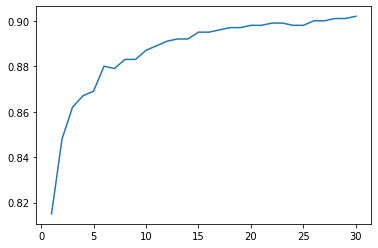

In [41]:
modelx = MLP_Net()
η = 0.002 #If it too big, it will fail!
mini_batch_size = 50
nb_epochs =30
acc_epoch = []
#print(train_input, train_target)
for e in range(nb_epochs):
    #print(train_input_1, train_classes_1)
    modelx, acc_loss = train_model1(modelx, train_input_1[:, 0], train_classes_1, mini_batch_size)
    acc, output_class_1 = compute_nb_errors(modelx, test_input_1, test_classes_1, mini_batch_size)
    modelx, acc_loss = train_model1(modelx, train_input_2, train_classes_2, mini_batch_size)
    acc, output_class_2 = compute_nb_errors(modelx, test_input_2, test_classes_2, mini_batch_size)
    
    # print('epoch :', e, ' loss :', round(acc_loss))
    # print('acc : ', acc)
    # print('----------')
    acc_epoch.append(acc)
# plotting
my_plot(np.linspace(1, nb_epochs, nb_epochs).astype(int), acc_epoch)
print('test_input_1 acc : ', acc)
summary(modelx, (1, 14, 14))